### Python setup

See `README.md` for python environment setup instructions on OSX using `pyenv` in VSCode.  If you've got another way of getting a modern, viable python environment, feel free to use it.

Here are the versions that I'm using when running this notebook:

In [1]:
%%bash
python -V
pip -V

Python 3.12.2
pip 24.0 from /Users/tednaleid/.pyenv/versions/3.12.2/envs/d2notebooks-3.12.2/lib/python3.12/site-packages/pip (python 3.12)


In [2]:
# install dependencies with `pip` 
! pip install requests pandas matplotlib

### API Key and Client ID

You'll need an API Key and Client ID to interact with Bungie's API.  You can generate one on Bungie's website: https://www.bungie.net/en/Application

You can generate an application with the "Public" OAuth type with a redirect url of: `https://localhost:7777/oauth-redirect`  - this will be used after the oauth login to get the oauth token that will be used in API requests

The only scope necessary is read access: `Read your Destiny 2 information (Vault, Inventory, and Vendors), as well as Destiny 1 Vault and Inventory data` 

This is what it should look like:

![Image](images/oauth-app-settings.png)


Once you create your application, you should get an `OAuth client_id` and an `API Key`, values for these should be put into `config.json`, so they can be read in the next cell:


In [3]:
# load the config file that holds the client_id and api_key used to talk to the Bungie API.
# we are using the "Public" method and only making read-only requests, so we don't need the client_secret
# this also means that our tokens will only be good for 1 hour

import json
import os

def load_config():
    # If config.json is not present, create it with default content
    if not os.path.exists('config.json'):
        with open('config.json', 'w') as file:
            # don't modify this as it'll get checked in, let it create the default file and then you can modify it
            json.dump({ "client_id": "your_client_id", "api_key": "your_api_key"}, file, indent=4)

    with open('config.json', 'r') as file:
        data = json.load(file)

    return data

data = load_config()
client_id = data['client_id']
api_key = data['api_key']

assert client_id != '' and client_id != "your_client_id", "Please enter your client_id in the config.json file"
assert api_key != '' and api_key != "your_api_key", "Please enter your client_id in the config.json file"

### Generate a self-signed cert that we can use for the https redirect

You'll need to tell your browser to "trust" this cert after the redirect

In [4]:
%%bash
if [[ -f "key.pem" ]]; then
    echo "key.pem already exists, not regenerating it.  Delete if if you'd like to regenerate it."
else
    openssl req -x509 -newkey rsa:4096 -keyout key.pem -out cert.pem -days 365 -nodes -subj "/C=US/ST=California/L=San Francisco/O=My Company/OU=My Division/CN=localhost"
fi

key.pem already exists, not regenerating it.  Delete if if you'd like to regenerate it.


### Login with OAuth to get a token that'll last for 1 hour

In [5]:
import queue
import http.server
import ssl
import threading
from urllib.parse import urlparse, parse_qs
import requests
import os
import base64
import queue

class RedirectHandler(http.server.SimpleHTTPRequestHandler):
    def log_message(self, format, *args):
        return

    def do_GET(self):
        # Parse the URL and put the query parameters in the queue back to the main thread
        parsed_url = urlparse(self.path)
        query_params = parse_qs(parsed_url.query)
        self.server.queue.put(query_params)

        self.send_response(200)
        self.end_headers()
        self.wfile.write(b'Access token transmitted to notebook. You can close this window now.')
        
        return

# needs to be run on a separete thread because it blocks
# it takes a queue to put the query parameters in to communicate to the main thread
def create_https_server(port, certfile, keyfile, queue):
    httpd = http.server.HTTPServer(('localhost', port), RedirectHandler)
    httpd.queue = queue
    context = ssl.SSLContext(ssl.PROTOCOL_TLS_SERVER)
    context.load_cert_chain(certfile, keyfile)
    httpd.socket = context.wrap_socket(httpd.socket, server_side=True)
    server_thread = threading.Thread(target=httpd.serve_forever)
    server_thread.start()
    return httpd, server_thread

def stop_https_server(httpd, server_thread):
    if httpd is None or server_thread is None:
        return
    print('Stopping HTTPS server')
    httpd.shutdown()
    httpd.socket.close()
    server_thread.join()

# currently, we're not really using this for verification, a later enhancement could be to verify the code in the response
def pkce_verifier(length):
    return base64.urlsafe_b64encode(os.urandom(length)).decode('utf-8')

def login_with_pkce(client_id, redirect_url):
    # start the server
    q = queue.Queue()
    httpd, server_thread = create_https_server(7777, 'cert.pem', 'key.pem', q)

    state = pkce_verifier(128)

    authorization_url = f"https://www.bungie.net/en/oauth/authorize?client_id={client_id}&response_type=code&state={state}&redirect_uri={redirect_url}"

    print(f"Please go to the following URL and authorize the app: {authorization_url}")

    query_params = q.get()

    stop_https_server(httpd, server_thread)

    # Extract the code from the query parameters and return it, we don't want the array, we want the first value
    code = query_params['code'][0]

    return code

def get_token_json(code, client_id):
    url = "https://www.bungie.net/platform/app/oauth/token/"
    data = {
        "grant_type": "authorization_code",
        "code": code,
        "client_id": client_id
    }
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    response = requests.post(url, data=data, headers=headers)
    return response.json()

def login_and_get_token(client_id, redirect_url):
    code = login_with_pkce(client_id, redirect_url)
    token_json = get_token_json(code, client_id)
    token = token_json['access_token']
    token_json['access_token'] = f"[REDACTED - length: {len(token)}]"
    print(json.dumps(token_json, indent=4))
    return token

In [6]:
# perform oauth login to get the access token used in later requests.  It is good for 1 hour
print("We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.")
access_token = login_and_get_token(client_id, "https://localhost:7777/oauth-redirect")

We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.
Please go to the following URL and authorize the app: https://www.bungie.net/en/oauth/authorize?client_id=22927&response_type=code&state=EJ9l76FCcUUspmr1qbwt1Li4AJCC-T6tdxflJv7OSwerHc8BHOZ7-ujl0bOTBsFnIsiCfPxC6M5jILFAxAkaN_mIxOY4rFHjb_FEg8n8vgCLz2XRqgqcdE-A_C91YDgNAMfbaUDLfop4yxJvliQmsh0GdKcE8NqIQGtNseHgMtU=&redirect_uri=https://localhost:7777/oauth-redirect
Stopping HTTPS server
{
    "access_token": "[REDACTED - length: 360]",
    "token_type": "Bearer",
    "expires_in": 3600,
    "membership_id": "10033089"
}


### Now we're ready to talk to Bungie's API

In [7]:
import requests
from urllib.parse import quote

def default_headers():
    return {
        'X-API-Key': api_key,
    }

def get_primary_membership_id_and_type(access_token, username):
    username = quote(username)
    url = f"https://www.bungie.net/Platform/Destiny2/SearchDestinyPlayer/-1/{username}/"
    response = requests.get(url, headers=default_headers())
    data = response.json()
    
    for player in data['Response']:
        membership_id = player['membershipId']
        membership_type = player['membershipType']
        print(f"Checking membership ID {membership_id} with membership type {membership_type}")
        profile_url = f"https://www.bungie.net/Platform/Destiny2/{membership_type}/Profile/{membership_id}/?components=100"
        profile_response = requests.get(profile_url, headers=default_headers())
        profile_data = profile_response.json()
        if 'profile' in profile_data['Response'] and profile_data['Response']['profile']['data']['userInfo']['crossSaveOverride'] == membership_type:
            print(f"Crosave override found for {membership_id}")
            return membership_id, membership_type

    return None

def get_character_ids_and_classes(access_token, membership_id, membership_type):
    url = f"https://www.bungie.net/Platform/Destiny2/{membership_type}/Profile/{membership_id}/?components=200"
    response = requests.get(url, headers=default_headers())
    data = response.json()
    
    character_data = data['Response']['characters']['data']
    character_ids_and_classes = {}
    for character_id, character_info in character_data.items():
        class_type = character_info['classType']
        if class_type == 0:
            class_name = 'Titan'
        elif class_type == 1:
            class_name = 'Hunter'
        elif class_type == 2:
            class_name = 'Warlock'
        else:
            class_name = 'Unknown'
        character_ids_and_classes[character_id] = class_name

    return character_ids_and_classes

### Retrieve the membership ID for your user account

Update the `username` field with your bungie username, steam names will have a `#<4 digits>` on the end.  

You will not be able to use my username and have the scripts below work because many of them are getting non-public (but read-only) info about vault equipment.

This same username is used on things like https://dungeon.report to find your user.

In [8]:
username = 'ted#2434'

membership_id, profile_type = get_primary_membership_id_and_type(access_token, username)
print(f"Membership ID: {membership_id}, Profile Type: {profile_type}")

get_character_ids_and_classes(access_token, membership_id, profile_type)

Checking membership ID 4611686018436088066 with membership type 2
Crosave override found for 4611686018436088066
Membership ID: 4611686018436088066, Profile Type: 2


{'2305843009262789149': 'Titan',
 '2305843009262789151': 'Warlock',
 '2305843009665494246': 'Hunter'}

In [9]:
# a bunch of helper functions to get the manifest and profile information
import requests

def get_manifest():
    url = f'https://www.bungie.net/Platform/Destiny2/Manifest/'
    print(url)

    response = requests.get(url, headers=default_headers())
    response.raise_for_status()

    manifest = response.json()

    return manifest

def get_item_definitions(manifest):
    item_definitions_url = f'https://www.bungie.net{manifest["Response"]["jsonWorldComponentContentPaths"]["en"]["DestinyInventoryItemDefinition"]}'

    print(item_definitions_url)

    response = requests.get(item_definitions_url, headers=default_headers())
    response.raise_for_status()

    item_definitions = response.json()

    return item_definitions

def get_stat_definitions(manifest):
    stat_definitions_url = f'https://www.bungie.net{manifest["Response"]["jsonWorldComponentContentPaths"]["en"]["DestinyStatDefinition"]}'

    print(stat_definitions_url)

    response = requests.get(stat_definitions_url, headers=default_headers())
    response.raise_for_status()

    stat_definitions = response.json()

    return stat_definitions

# full description of components are on the bungie API documentation: https://bungie-net.github.io/multi/schema_Destiny-DestinyComponentType.html
def get_profile(access_token, membership_type, membership_id, components):
    headers = default_headers() 
    headers['Authorization'] = f'Bearer {access_token}'

    url = f'https://www.bungie.net/Platform/Destiny2/{membership_type}/Profile/{membership_id}/?components={ ','.join(str(c) for c in components)}'
    print(url)

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()['Response']
    return data

def print_shallow_dict(d):
    # list out the top level properties and their child properties, if they are dictionaries
    for key, value in d.items():
        if isinstance(value, dict):
            print(key)
            for child_key, child_value in value.items():
                print(f'  {child_key} : {child_value}')
        else: 
            print(f'{key} : {value}')


In [10]:
# retrieve the manifest and item/stat definitions that will be joined with profile data to determine what armor you have in your vault
manifest = get_manifest()
item_definitions = get_item_definitions(manifest)
stat_definitions = get_stat_definitions(manifest)

https://www.bungie.net/Platform/Destiny2/Manifest/
https://www.bungie.net/common/destiny2_content/json/en/DestinyInventoryItemDefinition-22a989bc-8fbc-4cc3-bedb-5b0a4ee8f3ef.json
https://www.bungie.net/common/destiny2_content/json/en/DestinyStatDefinition-22a989bc-8fbc-4cc3-bedb-5b0a4ee8f3ef.json


In [11]:
# access_token, profile_type, and membership_id should be retrieved above 
# using the login_and_get_token and get_primary_membership_id_and_type functions

# https://bungie-net.github.io/multi/schema_Destiny-DestinyComponentType.html#schema_Destiny-DestinyComponentType
# 100 = profile.data.userInfo
# 102 = profileInventory.data.items
# 205 = characterEquipment.data[character_id].items
# 300 = itemComponents.instances
# 305 = profilePlugSets.data.plugs, characterPlugSets.data[character_id].plugs, itemComponents.sockets

# this gives us all of the information we need for vault armor for this user
profile = get_profile(access_token, profile_type, membership_id, [100,102,205,300,305])

print_shallow_dict(profile)

https://www.bungie.net/Platform/Destiny2/2/Profile/4611686018436088066/?components=100,102,205,300,305
responseMintedTimestamp : 2024-05-18T20:09:56.14Z
secondaryComponentsMintedTimestamp : 0001-01-01T00:00:00Z
profileInventory
  data : {'items': [{'itemHash': 2367713531, 'quantity': 4, 'bindStatus': 0, 'location': 2, 'bucketHash': 1469714392, 'transferStatus': 2, 'lockable': False, 'state': 0, 'dismantlePermission': 0, 'isWrapper': False, 'tooltipNotificationIndexes': []}, {'itemHash': 3282419336, 'quantity': 100, 'bindStatus': 0, 'location': 2, 'bucketHash': 1469714392, 'transferStatus': 2, 'lockable': False, 'state': 0, 'dismantlePermission': 0, 'isWrapper': False, 'tooltipNotificationIndexes': []}, {'itemHash': 1293574817, 'quantity': 39, 'bindStatus': 0, 'location': 2, 'bucketHash': 1469714392, 'transferStatus': 0, 'lockable': False, 'state': 0, 'dismantlePermission': 0, 'isWrapper': False, 'tooltipNotificationIndexes': []}, {'itemHash': 937378714, 'quantity': 50, 'bindStatus': 0,

In [12]:
# functions to parse the profile data and create the Dict of Armor the user has on all characters and in the vault
from dataclasses import dataclass, field
from typing import Dict
import pandas as pd
import random
random.seed(42)

def random_64_int():
    return random.randint(0,9223372036854775807)

# the stats on the armor are the base values, they do not include masterworking or other mods
@dataclass
class Armor:
    item_name: str = "Generic Armor"
    item_hash: str = field(default_factory=random_64_int)
    instance_id: str = field(default_factory=random_64_int)
    rarity: str = "Legendary"
    slot: str = "Helmet"
    power: int = 0 
    mobility: int = 0
    resilience: int = 0
    recovery: int = 0
    discipline: int = 0
    intellect: int = 0
    strength: int = 0
    is_artifice: bool = False
    is_masterworked: bool = False
    d2_class: str = "Warlock"

    @property
    def is_exotic(self):
        return self.rarity == "Exotic"

    @property
    def total_stats(self):
        return self.mobility + self.resilience + self.recovery + self.discipline + self.intellect + self.strength

    @property
    def class_slot(self):
        return f"{self.d2_class} {self.slot}"

    def __hash__(self):
        return hash(self.instance_id)

# hard coding some magic numbers, these are in DestinyStatDefinition.json
MOBILITY_ID = "2996146975"
RESILIENCE_ID = "392767087"
RECOVERY_ID = "1943323491"
DISCIPLINE_ID = "1735777505"
INTELLECT_ID = "144602215"
STRENGTH_ID = "4244567218"

CLASS_MAP = {0: 'Titan', 1: 'Hunter', 2: 'Warlock'}

ARMOR_ITEM_TYPE = 2

# spin through the profile data and find all inventory items on the character and in character equipment
# example for item instance: {'itemHash': 2244604734, 'itemInstanceId': '6917529860806551003', 'quantity': 1, 'bindStatus': 0, 'location': 2, 'bucketHash': 138197802, 'transferStatus': 0, 'lockable': True, 'state': 5, 'dismantlePermission': 2, 'isWrapper': False, 'tooltipNotificationIndexes': [], 'versionNumber': 0 }
def get_inventory_items(profile):
    items = {}
    for character_id in profile['profile']['data']['characterIds']:
        for item in profile['characterEquipment']['data'][character_id]['items']:
            instance_id = item.get('itemInstanceId', item['itemHash'])
            items[instance_id] = item

    for item in profile['profileInventory']['data']['items']:
        instance_id = item.get('itemInstanceId', item['itemHash'])
        items[instance_id] = item

    return items

# example for instance: {'damageType': 0, 'primaryStat': {'statHash': 3897883278, 'value': 1810}, 'itemLevel': 181, 'quality': 0, 'isEquipped': False, 'canEquip': False, 'equipRequiredLevel': 50, 'unlockHashesRequiredToEquip': [1368285237], 'cannotEquipReason': 16, 'energy': {'energyTypeHash': 4069572561, 'energyType': 3, 'energyCapacity': 10, 'energyUsed': 0, 'energyUnused': 10}
def get_item_component_instances(profile):
    item_component_instances = {}
    for instance_id, instance in profile['itemComponents']['instances']['data'].items():
        item_component_instances[instance_id] = instance
    
    return item_component_instances

# example sockets for instance: sockets': [{'plugHash': 1980618587, 'isEnabled': True, 'isVisible': True}, {'plugHash': 3820147479, 'isEnabled': True, 'isVisible': True}, {'plugHash': 3820147479, 'isEnabled': True, 'isVisible': True}, {'plugHash': 3820147479, 'isEnabled': True, 'isVisible': True}, {'plugHash': 4248210736, 'isEnabled': True, 'isVisible': True}, {'plugHash': 902052880, 'isEnabled': True, 'isVisible': True}, {'plugHash': 1390278942, 'isEnabled': True, 'isVisible': False}, {'plugHash': 3581342943, 'isEnabled': True, 'isVisible': False}, {'plugHash': 166910052, 'isEnabled': True, 'isVisible': False}, {'plugHash': 2807591295, 'isEnabled': True, 'isVisible': False}, {'plugHash': 702981643, 'isEnabled': True, 'isVisible': True}, {'plugHash': 4173924323, 'isEnabled': True, 'isVisible': True}, {'plugHash': 3727270518, 'isEnabled': True, 'isVisible': True}]
def get_item_component_sockets(profile):
    item_component_sockets = {}
    for instance_id, sockets in profile['itemComponents']['sockets']['data'].items():
        item_component_sockets[instance_id] = sockets['sockets']
    
    return item_component_sockets

# returns a dictionary of all items in the profile, keyed by the instance_id and joined with itemComponents and sockets
def get_all_inventory_items(profile):
    inventory_items = get_inventory_items(profile)
    item_component_instances = get_item_component_instances(profile)
    item_component_sockets = get_item_component_sockets(profile)

    # join the instances and sockets to the inventory items when present
    for instance_id, item in inventory_items.items():
        item['itemComponents'] = item_component_instances.get(instance_id, None)
        item['sockets'] = item_component_sockets.get(instance_id, None)
        

    return inventory_items

# expects the output of `get_all_inventory_items` and returns a list of all armor items
def get_armor_dict(all_items): 
    armor_items = {}

    for item in all_items.values():
        armor = convert_to_armor(item)
        if armor is not None:
            armor_items[armor.instance_id] = armor

    return armor_items


# given an item from `get_all_inventory_items` turn it into an Armor object joined with information from other manifests
# yeah... this is a mess.  if there is a better way to do this, I'd love to hear it
# bungie's API has plugs for armor stats, 4 per armor piece and they each have 3 of the stats on them
# also, if the armor is artifice, we have to parse that out as a separate socket by name as well
def convert_to_armor(item):

    # print(json.dumps(item, indent=4))

    if item is None or 'itemHash' not in item or 'itemInstanceId' not in item:
        return None

    instance_id = item['itemInstanceId']
    item_hash = item['itemHash']
    item_definition = item_definitions[str(item_hash)]
    item_type = item_definition['itemType']

    if item_type == ARMOR_ITEM_TYPE:
        mobility = 0
        resilience = 0
        recovery = 0
        discipline = 0
        intellect = 0
        strength = 0
        is_artifice = False

        item_name = item_definition['displayProperties']['name']

        if instance_id is None:
            print(f'No instance ID for item {item_hash} - {item_definition}')
            return None

        item_components = item.get('itemComponents', None)
        if item_components is None:
            print(f'No itemComponents for item {item_hash} - {item_definition}')
            return None

        sockets = item.get('sockets', None)

        if sockets is None:
            print(f'No sockets for item {item_hash} - {item_definition}')
            return None

        for socket in sockets:
            # if it doesn't have a `plugHash` we don't care about it
            if 'plugHash' not in socket:
                continue

            plug_hash = str(socket['plugHash'])

            plug_definition = item_definitions[plug_hash]

            if plug_definition is None:
                print(f'No plug definition for plug {plug_hash}')
                continue

            # print(json.dumps(plug_definition, indent=4))

            plug_name = plug_definition['displayProperties']['name']

            if plug_name == "Artifice Armor":
                is_artifice = True
                continue

            investment_stats = plug_definition.get('investmentStats', None)

            # we're looking for the 4 plugs that have 3 investment stats each
            # these are in groups of Mob/Res/Rec and Dis/Int/Str
            # there's another possible slot here if it is masterworked
            # or it has a stat mod on it where the length can be 7, we don't want that
            if investment_stats is None:
                continue
            elif len(investment_stats) != 3: # masterworked/stat modded armor has 7 stats
                # print(json.dumps(plug_definition, indent=4))
                continue

            for stat in investment_stats:
                stat_hash = str(stat['statTypeHash'])
                stat_value = stat['value']

                if stat_value == 0:
                    continue
                elif stat_hash == MOBILITY_ID:
                    mobility += stat_value
                elif stat_hash == RESILIENCE_ID:
                    resilience += stat_value
                elif stat_hash == RECOVERY_ID:
                    recovery += stat_value
                elif stat_hash == DISCIPLINE_ID:
                    discipline += stat_value
                elif stat_hash == INTELLECT_ID:
                    intellect += stat_value
                elif stat_hash == STRENGTH_ID:
                    strength += stat_value
                else:
                    print(f'Unknown stat hash {stat_hash} for plug {plug_hash}')

 
        rarity = item_definition['inventory']['tierTypeName']
        slot = item_definition.get('itemTypeDisplayName', 'Unknown')
        power = item_components['primaryStat']['value']

        # there's a way to determine this with sockets/plugs, but it is gross, I think checking for energy of 10 cleaner on armor
        is_masterworked = item_components['energy']['energyCapacity'] == 10

        if slot == "Warlock Bond" or slot == "Titan Mark" or slot == "Hunter Cloak":
            slot = "Class Item"

        d2_class = CLASS_MAP.get(item_definition['classType'], 'Unknown')

        armor = Armor(
            item_name=item_name,
            item_hash=item_hash,
            instance_id=instance_id,
            rarity=rarity,
            slot=slot,
            power=power,
            mobility=mobility,
            resilience=resilience,
            recovery=recovery,
            discipline=discipline,
            intellect=intellect,
            strength=strength,
            is_artifice=is_artifice,
            is_masterworked=is_masterworked,
            d2_class=d2_class
        )
        return armor


In [13]:
all_items = get_all_inventory_items(profile)
all_items_df = pd.DataFrame(all_items)
all_items_df


,6917529878568064740,6917529903432451418,6917529210105762685,6917529815104854677,6917529871224003792,6917529857906618905,6917529823402521839,6917529942979833410,6917529871283981258,6917529199495835233,...,6917529951487696768,6917529960105883825,6917529951491032359,6917529882311993983,6917529873277044290,6917529883192953649,6917529938225098857,6917529960103865660,6917529834873405734,6917529936709740897
itemHash,2715240478,1123421440,3487253372,2240729575,241462142,839296981,1640403802,4050474396,1490914249,3317837688,...,2203146422,3513993870,2773056939,2598029856,164103153,2787963735,820890091,2923110818,2808156426,1906093346
itemInstanceId,6917529878568064740,6917529903432451418,6917529210105762685,6917529815104854677,6917529871224003792,6917529857906618905,6917529823402521839,6917529942979833410,6917529871283981258,6917529199495835233,...,6917529951487696768,6917529960105883825,6917529951491032359,6917529882311993983,6917529873277044290,6917529883192953649,6917529938225098857,6917529960103865660,6917529834873405734,6917529936709740897
quantity,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
bindStatus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
location,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
bucketHash,1498876634,2465295065,953998645,3448274439,3551918588,14239492,20886954,1585787867,4023194814,2025709351,...,138197802,138197802,138197802,138197802,138197802,138197802,138197802,138197802,138197802,138197802
transferStatus,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
lockable,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
state,5,5,1,4,5,5,5,5,0,1,...,1,0,0,1,1,0,8,0,0,5
dismantlePermission,2,2,1,2,1,2,2,2,1,1,...,1,2,1,2,2,2,2,2,1,1


In [14]:
# print out the JSON for the first item in the dictionary of all_items
print(json.dumps(next(iter(all_items.values())), indent=4))

{
    "itemHash": 2715240478,
    "itemInstanceId": "6917529878568064740",
    "quantity": 1,
    "bindStatus": 0,
    "location": 1,
    "bucketHash": 1498876634,
    "transferStatus": 1,
    "lockable": true,
    "state": 5,
    "dismantlePermission": 2,
    "isWrapper": false,
    "tooltipNotificationIndexes": [],
    "versionNumber": 0,
    "itemComponents": {
        "damageType": 6,
        "damageTypeHash": 151347233,
        "primaryStat": {
            "statHash": 1480404414,
            "value": 1810
        },
        "itemLevel": 181,
        "quality": 0,
        "isEquipped": true,
        "canEquip": true,
        "equipRequiredLevel": 50,
        "unlockHashesRequiredToEquip": [
            2166136261
        ],
        "cannotEquipReason": 0
    },
    "sockets": [
        {
            "plugHash": 878286503,
            "isEnabled": true,
            "isVisible": true
        },
        {
            "plugHash": 839105230,
            "isEnabled": true,
            "i

In [15]:
# example masterworked artifice armor - you'll need to find your own armor instance ID from above to see and example in your vault
convert_to_armor(all_items['6917529860806551003'])

Armor(item_name='Corrupting Echo Gloves', item_hash=2244604734, instance_id='6917529860806551003', rarity='Legendary', slot='Gauntlets', power=1810, mobility=21, resilience=10, recovery=2, discipline=20, intellect=2, strength=9, is_artifice=True, is_masterworked=True, d2_class='Warlock')

In [16]:
armor_dict = get_armor_dict(all_items)

In [17]:
import pandas as pd
armor_df = pd.DataFrame([{
    **vars(armor), 
    'total_stats': armor.total_stats,
    'is_exotic': armor.is_exotic,
    'class_slot': armor.class_slot
} for armor in armor_dict.values()])

armor_df

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
0,Tusked Allegiance Helmet,2240729575,6917529815104854677,Legendary,Helmet,1810,2,23,7,21,10,2,False,True,Titan,65,False,Titan Helmet
1,Synthoceps,241462142,6917529871224003792,Exotic,Gauntlets,1810,2,16,13,17,2,10,False,True,Titan,60,True,Titan Gauntlets
2,Warmind's Avatar Chestplate,839296981,6917529857906618905,Legendary,Chest Armor,1810,2,30,2,15,10,6,False,True,Titan,65,False,Titan Chest Armor
3,Ketchkiller's Greaves,1640403802,6917529823402521839,Legendary,Leg Armor,1809,6,22,6,23,8,2,False,True,Titan,67,False,Titan Leg Armor
4,Descending Echo Mark,4050474396,6917529942979833410,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Titan,0,False,Titan Class Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Techeun's Regalia Grips,164103153,6917529873277044290,Legendary,Gauntlets,1783,18,2,12,14,8,10,False,False,Hunter,64,False,Hunter Gauntlets
193,Vest of Trepidation,2787963735,6917529883192953649,Legendary,Chest Armor,1800,12,8,13,2,21,7,False,False,Hunter,63,False,Hunter Chest Armor
194,Hinterland Vest,2923110818,6917529960103865660,Legendary,Chest Armor,1800,20,12,2,16,2,13,False,False,Hunter,65,False,Hunter Chest Armor
195,Eternal Warrior,2808156426,6917529834873405734,Exotic,Helmet,1600,2,13,17,17,12,2,False,False,Titan,63,True,Titan Helmet


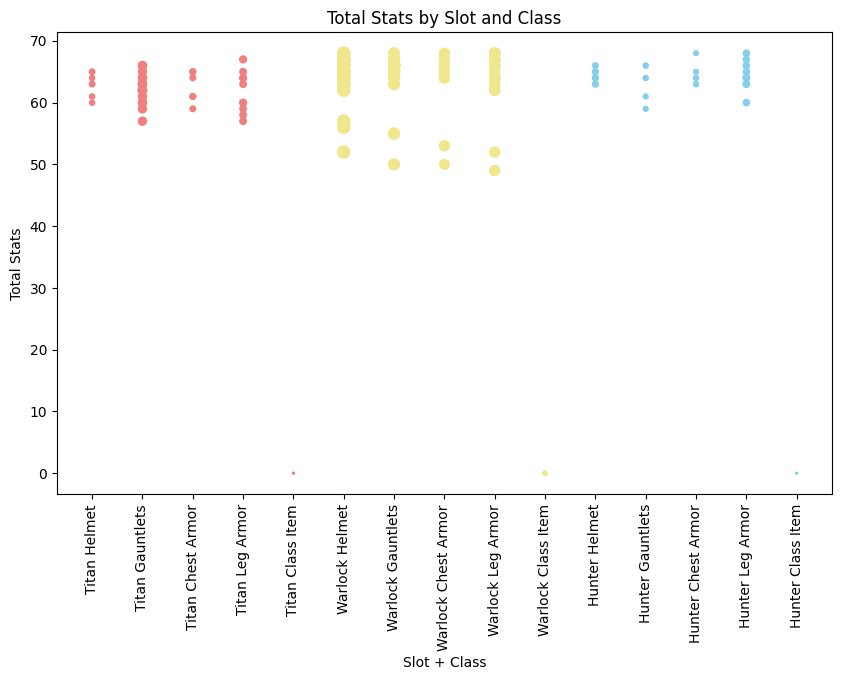

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a color map for the classes
color_map = {'Hunter': mcolors.CSS4_COLORS['skyblue'], 
             'Titan': mcolors.CSS4_COLORS['lightcoral'], 
             'Warlock': mcolors.CSS4_COLORS['khaki']}
armor_df['color'] = armor_df['d2_class'].map(color_map)

# Calculate the counts for each 'class_slot' value
counts = armor_df['class_slot'].value_counts()

plt.figure(figsize=(10,6))
# Pass the counts as the 's' argument to plt.scatter()
plt.scatter(armor_df['class_slot'], armor_df['total_stats'], s=counts[armor_df['class_slot']] * 2, color=armor_df['color'])
plt.xlabel('Slot + Class')
plt.ylabel('Total Stats')
plt.title('Total Stats by Slot and Class')
plt.xticks(rotation=90)
plt.show()

In [19]:
# currently omits class items from the comparison, keep one artifice class item and delete the rest (at least till exotic class items are added)
def find_lesser_pieces(group):
    # Sort the group in descending order by 'total_stats'
    sorted_group = group.sort_values('total_stats', ascending=False)
    
    # Iterate over the rows in the sorted group
    for i, row in sorted_group.iterrows():
        # we're currently omitting class items from the comparison
        if row.mobility == 0 and row.resilience == 0 and row.recovery == 0 and row.discipline == 0 and row.intellect == 0 and row.strength == 0:
            continue
        # Iterate over the rows again to compare each piece with every other piece
        for j, other_row in sorted_group.iterrows():
            if row.rarity != other_row.rarity:
                continue
            if i != j:
                # Compare all individual stats
                if (row[['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']] 
                    <= other_row[['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']]).all():
                    drow = row.to_dict()
                    orow = other_row.to_dict()
                    print(f"id:{drow['instance_id']} id:{orow['instance_id']}")
                    print(f"mob {drow['mobility']}\tres {drow['resilience']}\trec {drow['recovery']}\tdis {drow['discipline']}\tint {drow['intellect']}\tstr {drow['strength']}\t name {drow['item_name']}")
                    print(f"mob {orow['mobility']}\tres {orow['resilience']}\trec {orow['recovery']}\tdis {orow['discipline']}\tint {orow['intellect']}\tstr {orow['strength']}\t name {orow['item_name']}")

# Group 'armor_df' by 'class_slot' and apply 'find_lesser_pieces' to each group
armor_df.groupby('class_slot').apply(find_lesser_pieces)

id:6917529664322015082 id:6917529882311993983
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Tusked Allegiance Mask
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Techeun's Regalia Mask
id:6917529882311993983 id:6917529664322015082
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Techeun's Regalia Mask
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Tusked Allegiance Mask
id:6917529857906618905 id:6917529967583481167
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Warmind's Avatar Chestplate
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Wyrmguard Chestplate
id:6917529967583481167 id:6917529857906618905
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Wyrmguard Chestplate
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Warmind's Avatar Chestplate
id:6917530001406404775 id:6917529855693975489
mob 2	res 20	rec 7	dis 18	int 2	str 8	 name Ego Talon IV
mob 2	res 20	rec 10	dis 23	int 2	str 8	 name Tusked Allegiance Hood
id:6917530001406404775 id:6917529837738329352
mob 2	res 20	rec 7	dis 18	int 2	str 8	 name E

/var/folders/1c/r4j3m3gx0rdf3zxdq853b4jw0000gn/T/ipykernel_32218/4284941959.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  armor_df.groupby('class_slot').apply(find_lesser_pieces)


""


In [47]:
from itertools import product
from collections import defaultdict
from collections import namedtuple
import pandas as pd

# we want to generate outfits for a given class
# The high-level algorithm is:

# 1. filter armor to only include armor for the given class, also filter out class items
# 2. segregate the armor by whether it is exotic or not
# 3. group the exotic and non-exotic armor by slot
def filter_and_group_armor(armor_dict, d2_class, slots = ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"]):
    exotic_armor = defaultdict(list)
    non_exotic_armor = defaultdict(list)
    for armor in armor_dict.values():
        if armor.d2_class == d2_class and armor.slot in slots:
            if armor.is_exotic:
                exotic_armor[armor.slot].append(armor)
            else:
                non_exotic_armor[armor.slot].append(armor)

    if "Class Item" in non_exotic_armor:
        # class items all have the same stats, the only option is if one is artifice.  Pick one and remove the rest
        for armor in non_exotic_armor["Class Item"]:
            if armor.is_artifice:
                non_exotic_armor["Class Item"] = [armor]
                break

        if len(non_exotic_armor["Class Item"]) > 1:
            non_exotic_armor["Class Item"] = [non_exotic_armor["Class Item"][0]]

    return exotic_armor, non_exotic_armor

# 4. generate all possible outfits using non-exotic armor
# 5. add in all possible outfits using a single piece of exotic armor
def generate_class_outfits(armor_dict, d2_class):
    outfits = []

    # filter armor to only include armor for the given class and slots
    exotic_armor, non_exotic_armor = filter_and_group_armor(armor_dict, d2_class, ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"])

    # append all possible non-exotic armor combinations
    append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

    # we can only have exotic armor in a single slot, add all outfits with a single slot of exotic armor
    append_outfit_permutations(outfits, exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
    append_outfit_permutations(outfits, non_exotic_armor["Helmet"], exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
    append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
    append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

    # as of right now, there is no exotic class item.  there will be in TFS, but unless it has stats better than a legendary class item, we don't care
    # append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], exotic_armor["Class Item"])

    return outfits

Outfit = namedtuple('Outfit', ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength', 'helmet', 'gauntlets', 'chest_armor', 'leg_armor', 'class_item', 'num_artifice'])
ArtificeBonus = namedtuple('ArtificeBonus', ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength'])

def generate_artifice_permutations(num_artifice):
    # Generate all permutations of bonuses for each stat
    all_permutations = product(range(num_artifice + 1), repeat=6)

    # Filter the permutations to only include the ones with the correct total number of bonuses
    valid_permutations = [perm for perm in all_permutations if sum(perm) == num_artifice]

    # Convert the permutations to ArtificeBonus objects
    return [ArtificeBonus(*(i*3 for i in perm)) for perm in valid_permutations]

ARTIFICE_PERMUTATIONS = {i: generate_artifice_permutations(i) for i in range(6)}

# masterworking helmet, gauntlets, chest armor, leg armor, and class item gives a +10 bonus to each stat in an outfit
FULL_MASTERWORK_STAT_BONUS = 10

def round_to_useful_tier(stat):
    # stats above 100 aren't useful.  T10 is the highest tier
    if stat > 100:
        return 100

    # half tiers can be useful as there are 5 point mods, so we want to round down to the nearest 5
    return stat - (stat % 5)

def append_outfit_permutations(outfits, helmets, gauntlets, chest_armors, leg_armors, class_items):
    for helmet, gauntlet, chest_armor, leg_armor, class_item in product(helmets, gauntlets, chest_armors, leg_armors, class_items):
        # we want to add the masterwork stat bonus
        # armor pieces have base stats, without any mods or masterworking
        base_mobility = FULL_MASTERWORK_STAT_BONUS + helmet.mobility + gauntlet.mobility + chest_armor.mobility + leg_armor.mobility + class_item.mobility
        base_resilience = FULL_MASTERWORK_STAT_BONUS + helmet.resilience + gauntlet.resilience + chest_armor.resilience + leg_armor.resilience + class_item.resilience
        base_recovery = FULL_MASTERWORK_STAT_BONUS + helmet.recovery + gauntlet.recovery + chest_armor.recovery + leg_armor.recovery + class_item.recovery
        base_discipline = FULL_MASTERWORK_STAT_BONUS + helmet.discipline + gauntlet.discipline + chest_armor.discipline + leg_armor.discipline + class_item.discipline
        base_intellect = FULL_MASTERWORK_STAT_BONUS + helmet.intellect + gauntlet.intellect + chest_armor.intellect + leg_armor.intellect + class_item.intellect
        base_strength = FULL_MASTERWORK_STAT_BONUS + helmet.strength + gauntlet.strength + chest_armor.strength + leg_armor.strength + class_item.strength

        num_artifice = helmet.is_artifice + gauntlet.is_artifice + chest_armor.is_artifice + leg_armor.is_artifice + class_item.is_artifice

        append_outfit_permutation(outfits, base_mobility, base_resilience, base_recovery, base_discipline, base_intellect, base_strength, helmet.instance_id, gauntlet.instance_id, chest_armor.instance_id, leg_armor.instance_id, class_item.instance_id, num_artifice)

# recursively apply any artifice to the outfit
def append_outfit_permutation(outfits, mobility, resilience, recovery, discipline, intellect, strength, helmet, gauntlets, chest_armor, leg_armor, class_item, num_artifice):
    for artifice_bonus in ARTIFICE_PERMUTATIONS[num_artifice]:
        # TODO: do we want to try to exclude armor that isn't better than base armor would be?
        outfits.append(Outfit(
            mobility=round_to_useful_tier(mobility + artifice_bonus.mobility),
            resilience=round_to_useful_tier(resilience + artifice_bonus.resilience),
            recovery=round_to_useful_tier(recovery + artifice_bonus.recovery),
            discipline=round_to_useful_tier(discipline + artifice_bonus.discipline),
            intellect=round_to_useful_tier(intellect + artifice_bonus.intellect),
            strength=round_to_useful_tier(strength + artifice_bonus.strength),
            helmet=helmet,
            gauntlets=gauntlets,
            chest_armor=chest_armor,
            leg_armor=leg_armor,
            class_item=class_item,
            num_artifice=num_artifice
        ))


In [21]:
d2_class = "Hunter"
hunter_outfits = generate_class_outfits(armor_dict, d2_class)
print(f"Generated {len(hunter_outfits)} outfit permutations for {d2_class}")

d2_class = "Titan"
titan_outfits = generate_class_outfits(armor_dict, d2_class)
print(f"Generated {len(titan_outfits)} outfit permutations for {d2_class}")

d2_class = "Warlock"
warlock_outfits = generate_class_outfits(armor_dict, d2_class)
print(f"Generated {len(warlock_outfits)} outfit permutations for {d2_class}")

Generated 2540 outfit permutations for Hunter
Generated 13056 outfit permutations for Titan
Generated 8329896 outfit permutations for Warlock


In [22]:
import pandas as pd

# convert warlock outfits to a dataframe
warlock_outfits_df = pd.DataFrame(warlock_outfits)
warlock_outfits_df['total_points'] = warlock_outfits_df[['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']].sum(axis=1)
warlock_outfits_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
0,25,95,30,90,25,40,6917529999962955646,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,2,305
1,25,95,30,90,25,40,6917529999962955646,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,2,305
2,25,95,30,90,30,35,6917529999962955646,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,2,305
3,25,95,30,90,25,40,6917529999962955646,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,2,305
4,25,95,30,90,25,35,6917529999962955646,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,2,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329891,60,50,50,70,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,315
8329892,60,50,50,75,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,320
8329893,60,50,55,70,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,320
8329894,60,50,50,70,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,315


In [23]:
# todo: start here - can we pare down the number of artifice permutations to ones that matter?
# how much redundancy is in the list below for this exotic armor piece?


# one of my specific outfits I can see in DIM
crown_of_tempests_id="6917529798174050595"
corrupting_echo_gloves_id="6917529970716463834"
ketchkillers_robes_id="6917529822099480651"
deep_explorer_boots_id="6917529796979541985"
outfit = warlock_outfits_df.loc[
    (warlock_outfits_df['helmet'] == crown_of_tempests_id) & 
    (warlock_outfits_df['gauntlets'] == corrupting_echo_gloves_id) & 
    (warlock_outfits_df['chest_armor'] == ketchkillers_robes_id) &
    (warlock_outfits_df['leg_armor'] == deep_explorer_boots_id)]

outfit

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points


In [24]:
# Sort by total_points
sorted_df = warlock_outfits_df.sort_values('total_points', ascending=False)

# Drop duplicate rows based on the stat columns
unique_df = sorted_df.drop_duplicates(subset=['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength'])

unique_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
1238008,40,70,55,75,35,60,6917529861485659605,6917529860806551003,6917529784431753951,6917529953892340067,6917529583788947730,4,335
1134057,35,65,65,100,25,45,6917529862717276417,6917529557407159661,6917529784431753951,6917529862711137071,6917529583788947730,5,335
5321668,35,50,85,75,30,60,6917529861485659605,6917529953444804835,6917529970723712268,6917529862711137071,6917529583788947730,4,335
5377344,40,45,85,85,30,50,6917529862427248275,6917529998335931699,6917529861527043051,6917529939356501718,6917529583788947730,3,335
1211125,20,95,60,90,30,40,6917529861485659605,6917529838031225999,6917529784431753951,6917529861820030545,6917529583788947730,5,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70234,30,55,40,60,30,35,6917529999962955646,6917530005622390869,6917529999962957167,6917530000351948132,6917529583788947730,1,250
1617241,40,45,40,45,45,35,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250
1617242,40,45,40,50,40,35,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250
1617244,40,50,40,45,40,35,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250


In [25]:
from itertools import combinations

# Define a function that checks if any combination of 3 stats totals up to 250, which would allow a triple 100 build with five 10-point mods
def has_three_stats_totaling_250(row):
    stats = ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']
    return any(sum(row[stat] for stat in combination) == 250 for combination in combinations(stats, 3))

# Apply the function to each row of the DataFrame
mask = unique_df.apply(has_three_stats_totaling_250, axis=1)

# Create a new DataFrame that keeps only the rows where the function returned True
filtered_df = unique_df[mask]

filtered_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
5364135,20,80,70,100,25,40,6917529861485659605,6917529936709740897,6917529784431753951,6917529862711137071,6917529583788947730,4,335
6977426,20,60,90,100,25,35,6917529861485659605,6917529838031225999,6917529371276472828,6917529862711137071,6917529583788947730,4,330
6977460,20,70,80,100,25,35,6917529861485659605,6917529838031225999,6917529371276472828,6917529862711137071,6917529583788947730,4,330
6977020,20,90,60,100,25,35,6917529861485659605,6917529838031225999,6917529371276472828,6917529906176854077,6917529583788947730,3,330
2933824,70,80,20,100,35,25,6917529856623937918,6917529838031225999,6917529862445297720,6917529861820030545,6917529583788947730,4,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4757652,70,80,15,100,20,15,6917529862412909583,6917529936709740897,6917529862445297720,6917529862122801761,6917529583788947730,3,300
4757674,75,75,15,100,20,15,6917529862412909583,6917529936709740897,6917529862445297720,6917529862122801761,6917529583788947730,3,300
4318431,85,65,15,100,20,15,6917529862437575151,6917529936709740897,6917529862445297720,6917529862122801761,6917529583788947730,3,300
4318439,90,60,15,100,20,15,6917529862437575151,6917529936709740897,6917529862445297720,6917529862122801761,6917529583788947730,3,300


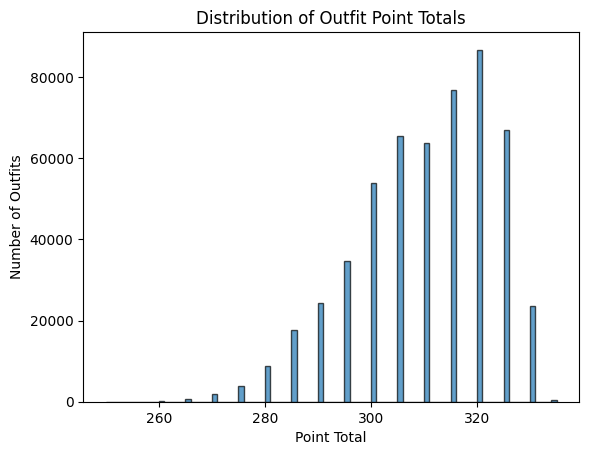

In [26]:
import matplotlib.pyplot as plt

# Calculate the point totals
point_totals = unique_df['total_points']

# Create a histogram of the point totals
plt.hist(point_totals, bins=range(min(point_totals), max(point_totals) + 1), alpha=0.7, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Outfit Point Totals')
plt.xlabel('Point Total')
plt.ylabel('Number of Outfits')

# Show the plot
plt.show()

In [27]:
# Create a dictionary to store the best outfit for each stat
best_outfits = {}

# Find the best outfit for each stat
for stat in ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']:
    # Sort by the stat, then the total_points
    best_outfit = warlock_outfits_df.sort_values([stat, 'total_points']).iloc[-1]
    best_outfits[stat] = best_outfit

best_outfits


{'mobility': mobility                        100
 resilience                       35
 recovery                         25
 discipline                      100
 intellect                        35
 strength                         35
 helmet          6917529862437575151
 gauntlets       6917529966912469338
 chest_armor     6917529862445297720
 leg_armor       6917529862122801761
 class_item      6917529583788947730
 num_artifice                      3
 total_points                    330
 Name: 4159776, dtype: object,
 'resilience': mobility                         20
 resilience                      100
 recovery                         45
 discipline                       75
 intellect                        45
 strength                         50
 helmet          6917529953895078815
 gauntlets       6917529928659315456
 chest_armor     6917529784431753951
 leg_armor       6917529861820030545
 class_item      6917529583788947730
 num_artifice                      3
 total_points     

# Tests

In [54]:
import unittest
random.seed(42)

class TestOutfits(unittest.TestCase):
    def armor_list_to_dict(self, armor_list):
        return {armor.instance_id: armor for armor in armor_list}

    def random_stat(self):
        return random.randint(1,42)
    
    def random_armor(self, slot, rarity="Legendary", item_hash=None):
        if item_hash is None:
            item_hash = random_64_int()
        return Armor(slot=slot, rarity=rarity, item_hash=item_hash, mobility=self.random_stat(), resilience=self.random_stat(), recovery=self.random_stat(), discipline=self.random_stat(), intellect=self.random_stat(), strength=self.random_stat())
    
    def setUp(self):
        self.titan_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, d2_class="Titan")
        self.helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6)
        self.artifice_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, is_artifice=True)
        self.gauntlets = Armor(slot="Gauntlets", mobility=7, resilience=7, recovery=7, discipline=7, intellect=7, strength=7)
        self.chest_armor = Armor(slot="Chest Armor", mobility=8, resilience=8, recovery=8, discipline=8, intellect=8, strength=8)
        self.leg_armor = Armor(slot="Leg Armor", mobility=9, resilience=9, recovery=9, discipline=9, intellect=9, strength=9)
        self.artifice_leg_armor = Armor(slot="Leg Armor", mobility=11, resilience=11, recovery=11, discipline=5, intellect=5, strength=20, is_artifice=True)
        self.class_item = Armor(slot="Class Item", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0)
        self.exotic_helmet = Armor(slot="Helmet", item_hash="veritys_brow", rarity="Exotic", mobility=2, resilience=20, recovery=10, discipline=30, intellect=2, strength=2)
        self.exotic_helmet2 = Armor(slot="Helmet", item_hash="veritys_brow", rarity="Exotic", mobility=11, resilience=11, recovery=11, discipline=11, intellect=11, strength=11)
        self.exotic_gauntlets = Armor(slot="Gauntlets", item_hash="necrotic_grips", rarity="Exotic", mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10)

        # all armor pieces in a dictionary keyed by instance_id
        self.armor_dict = self.armor_list_to_dict([
            self.titan_helmet,
            self.helmet,
            self.artifice_helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.artifice_leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])

    def test_armor(self):
        armor = self.helmet
        self.assertEqual(armor.total_stats, 36)
        self.assertEqual(armor.class_slot, "Warlock Helmet")
        self.assertFalse(armor.is_exotic)

        exotic_armor = self.exotic_helmet
        self.assertTrue(exotic_armor.is_exotic)

    def test_filter_and_group_armor(self):
        exotic_armor, non_exotic_armor = filter_and_group_armor(self.armor_dict, "Warlock")

        self.assertIsNotNone(exotic_armor)
        self.assertEqual(len(exotic_armor), 2)
        self.assertEqual(exotic_armor["Helmet"], [self.exotic_helmet, self.exotic_helmet2])
        self.assertEqual(exotic_armor["Gauntlets"], [self.exotic_gauntlets])
        self.assertIsNotNone(non_exotic_armor)
        self.assertEqual(len(non_exotic_armor), 5)
        self.assertEqual(non_exotic_armor["Helmet"], [self.helmet, self.artifice_helmet])
        self.assertEqual(non_exotic_armor["Gauntlets"], [self.gauntlets])
        self.assertEqual(non_exotic_armor["Chest Armor"], [self.chest_armor])
        self.assertEqual(non_exotic_armor["Leg Armor"], [self.leg_armor, self.artifice_leg_armor])
        self.assertEqual(non_exotic_armor["Class Item"], [self.class_item])

        exotic_armor, non_exotic_armor = filter_and_group_armor(self.armor_dict, "Titan")
        self.assertEqual(len(exotic_armor), 0)
        self.assertEqual(len(non_exotic_armor), 1)
        self.assertEqual(non_exotic_armor["Helmet"], [self.titan_helmet])

    def test_generate_class_outfits(self):
        armor_dict = self.armor_list_to_dict([
            self.helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])
        outfits = generate_class_outfits(armor_dict, "Warlock")
        self.assertEqual(len(outfits), 4)

        # point totals would be 44 for each stat, but we round down to the nearest 5 for the tier
        self.assertEqual(outfits[0], Outfit(mobility=40, resilience=40, recovery=40, discipline=40, intellect=40, strength=40, helmet=self.helmet.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[1], Outfit(mobility=35, resilience=50, recovery=40, discipline=60, intellect=35, strength=35, helmet=self.exotic_helmet.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[2], Outfit(mobility=45, resilience=45, recovery=45, discipline=45, intellect=45, strength=45, helmet=self.exotic_helmet2.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[3], Outfit(mobility=40, resilience=40, recovery=40, discipline=40, intellect=40, strength=40, helmet=self.helmet.instance_id, gauntlets=self.exotic_gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))

    def test_generate_many_class_outfits(self):
        armor_list=[]
        for i in range(10):
            armor_list.append(self.random_armor("Helmet"))
            armor_list.append(self.random_armor("Gauntlets"))
            armor_list.append(self.random_armor("Chest Armor"))
            armor_list.append(self.random_armor("Leg Armor"))
            armor_list.append(self.random_armor("Class Item"))

        armor_dict = self.armor_list_to_dict(armor_list)
        outfits = generate_class_outfits(armor_dict, "Warlock")
        # 4 slots with 20 pieces per slot, 10^4 = 10,000
        self.assertEqual(len(outfits), 10**4)

        for i in range(2):
            armor_list.append(self.random_armor("Helmet", "Exotic"))
            armor_list.append(self.random_armor("Gauntlets", "Exotic"))
            armor_list.append(self.random_armor("Leg Armor", "Exotic"))
            armor_list.append(self.random_armor("Chest Armor", "Exotic"))

        armor_dict = self.armor_list_to_dict(armor_list)
        outfits = generate_class_outfits(armor_dict, "Warlock")
        # same 4 slots with 10 legendary pieces per slot, but now 2 exotic pieces per slot that each need to be combined with 3 slots of 10 legendary pieces 
        self.assertEqual(len(outfits), 10**4 + 8 * 10**3)

unittest.main(argv=[''], verbosity=2, exit=False)

test_armor (__main__.TestOutfits.test_armor) ... ok
test_filter_and_group_armor (__main__.TestOutfits.test_filter_and_group_armor) ... ok
test_generate_class_outfits (__main__.TestOutfits.test_generate_class_outfits) ... ok
test_generate_many_class_outfits (__main__.TestOutfits.test_generate_many_class_outfits) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.298s

OK


# Utilities 

In [22]:
# download all manifest files to the data directory, assumes the `manifest` value is populated from above
# this isn't necessary, but it's nice to have the data locally to search through
os.makedirs('data', exist_ok=True)

for key, value in manifest['Response']['jsonWorldComponentContentPaths']['en'].items():
    print(f'Downloading {key} from {value}')
    response = requests.get(f'https://www.bungie.net{value}', headers=default_headers())
    with open(f'data/{key}.json', 'w') as f:
        f.write(response.text) 